In [279]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import numpy.random as npr


In [18]:
import csv
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    pos_data = [ row[0] for row in reader if float(row[1]) == 1.0]
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    neg_data = [ row[0] for row in reader if float(row[1]) == 0.0]

In [19]:
print len(pos_data)

2827


In [20]:
def print_topics(model, vocab, top_k=10):
    topic_words = model.topic_word_
    for i, topic_dist in enumerate(topic_words):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_k+1):-1]
        print('\tTopic {}: {}'.format(i+1, ', '.join(topic_words)))
        print
    print

In [21]:
all_data = pos_data + neg_data
labels = np.concatenate((np.ones(len(pos_data)), np.zeros(len(neg_data)))).astype(int)
cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=2, ngram_range=(1,1))
X = cv.fit_transform(all_data)
y = labels
vocab = [x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x:x[1])]


In [22]:
print X.shape, y.shape
n_topics = 10

(5394, 10731) (5394,)


In [23]:
from disclda.lda import DiscLDA
#model = DiscLDA(n_topics=n_topics, n_iter=1000, random_state=0)
#model.fit(X,y)

In [651]:
def run_disclda(data, labels, n_topics=10, n_per=1, n_iter=1000, random_state=0):
    print "Running LDA with %i topics and %i iterations..." % (n_topics, n_iter)
    cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=2, ngram_range=(1,1))
    X = cv.fit_transform(data)
    vocab = [x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x:x[1])]
    print "(N,V): ",X.shape
    print
    model = DiscLDA(n_topics=n_topics, n_per=n_per, n_iter=1000, random_state=0)
    model.fit(X, labels)
    results = {'n_topics':n_topics,
               'n_iter':n_iter,
               'vocab':vocab,
               'model':model,
               'X':X,
               'cv':cv
              }
    return results

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

In [280]:
from foodbornenyc.models import models as m, documents as d, businesses as b, locations as l
db = m.getDBSession()

In [30]:
%%time
bigreviews = db.query(d.YelpReview).limit(100000).all()

CPU times: user 3.33 s, sys: 531 ms, total: 3.87 s
Wall time: 24.4 s


In [32]:
%%time
fit_sample = [ r.text for r in np.random.choice(bigreviews, size=19000, replace=False)]
posn = 1000
data = pos_data[:posn] +fit_sample
labels = np.concatenate((np.ones(posn), np.zeros(len(fit_sample)))).astype(int)

CPU times: user 177 ms, sys: 3.96 ms, total: 181 ms
Wall time: 180 ms


In [33]:
print len(data)

20000


In [42]:
import logging
logging.getLogger("lda").setLevel(logging.ERROR)

In [34]:
%%time
result_mixed = run_disclda(data, labels, n_topics=50, n_per=1, n_iter=200)

Running LDA with 50 topics and 200 iterations...
(N,V): 

 (20000, 19379)

CPU times: user 6min 37s, sys: 632 ms, total: 6min 38s
Wall time: 6min 38s


In [35]:
print_topics(result_mixed['model'], result_mixed['vocab'], top_k=50)

	Topic 1: wine, great, place, selection, glass, nice, bottle, list, perfect, small, bar, little, staff, spot, friendly, food, service, date, delicious, wines, night, cozy, wonderful, excellent, beer, definitely, love, feel, menu, lovely, neighborhood, atmosphere, bottles, amazing, glasses, dinner, red, new, fantastic, favorite, cute, experience, knowledgeable, liquor, friends, extensive, white, helpful, decor, different

	Topic 2: food, sick, poisoning, got, night, ate, eating, stomach, hours, day, ordered, eat, went, diarrhea, vomiting, bad, later, place, days, restaurant, friend, health, feeling, worst, husband, ill, felt, terrible, boyfriend, feel, didn, dinner, people, friends, hour, home, morning, sure, horrible, bathroom, did, started, meal, stay, ended, avoid, severe, beware, case, experience

	Topic 3: sauce, flavor, dish, taste, little, sweet, bit, perfect, texture, nice, light, red, crispy, oil, bite, salt, served, flavors, mouth, salty, spicy, perfectly, fresh, right, white,

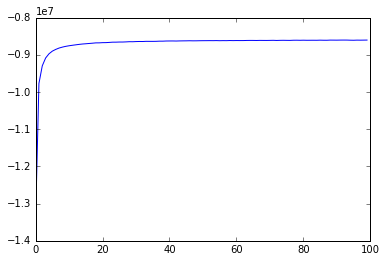

In [36]:
plt.plot(result_mixed['model'].loglikelihoods_)

In [43]:
thetas = result_mixed['model'].doc_topic_

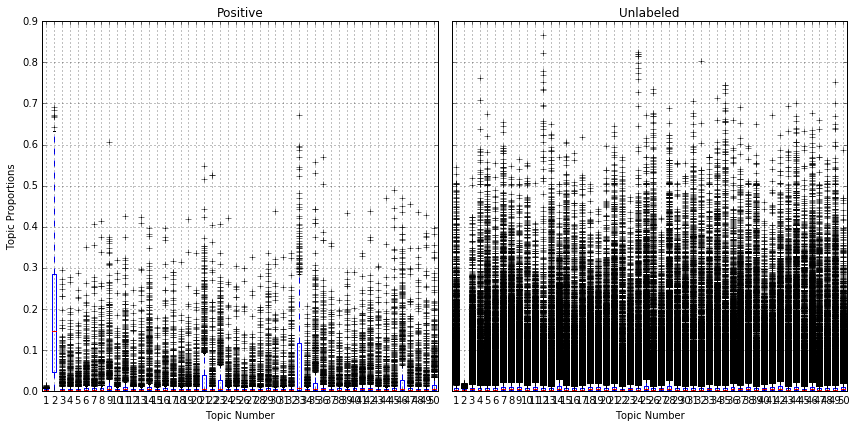

In [44]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6), sharey=True)
ax0.boxplot(thetas[:posn])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(thetas[posn:])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Unlabeled")
ax1.set_xlabel("Topic Number")

plt.tight_layout()
#plt.savefig('lda_boxplot_2500_7500.pdf')

### Fitting the $\Gamma$

In [45]:
import scipy.stats as st
def transform_doc(preprocess, model, doc):
    X = preprocess.transform([doc])
    #print X
    #print np.nonzero(X)
    return model.transform(X)

In [46]:
# get another random sample
gam_sample = [ r.text for r in np.random.choice(bigreviews, size=10000, replace=False)]

In [48]:
# get the alpha_2s of each doc in this sample
gvals = np.array([ transform_doc(result_mixed['cv'], result_mixed['model'], text)[0,1] for text in gam_sample])

In [49]:
# compute empirical gamma params
gbar = np.sum(gvals)/len(gvals)
#print gbar
gbar2 = gbar**2
#print gbar2
g2m = np.sum(gvals**2)/len(gvals)
#print g2m

# calculate shape estimate for gamma
den = g2m - gbar2
#print den
bhat = gbar/den #bhat is the RATE parameter = 1/SCALE
ahat = gbar2/den
print ahat, 1./bhat

0.0820108281365 0.0746511349252


In [50]:
# frozen empirical gamma for evaluation
empgam = st.gamma(ahat, scale=1./bhat)

In [601]:
def empgamma(gvals, n=1):
    # compute empirical gamma params
    gbar = np.sum(gvals)/float(len(gvals))
    #print gbar
    gbar2 = gbar**2
    #print gbar2
    g2m = np.sum(gvals**2)/float(len(gvals))
    #print g2m

    # calculate shape estimate for gamma
    den = g2m - gbar2
    #print den
    bhat = gbar/den #bhat is the RATE parameter = 1/SCALE
    ahat = gbar2/den
    return st.gamma(n*ahat, scale=1./bhat)

###  Looking at the empirical dist for individual reviews, both labeled and unlabeled

In [52]:
# pos data alpha2s for documents that we 1000 docs we didn't train on
pos_gs = [ transform_doc(result_mixed['cv'], result_mixed['model'], t)[0,1] for t in pos_data[posn:posn+1000]]

(array([ 0.023,  0.023,  0.034,  0.031,  0.035,  0.024,  0.042,  0.022,
         0.04 ,  0.032,  0.025,  0.034,  0.035,  0.029,  0.028,  0.022,
         0.018,  0.031,  0.015,  0.021,  0.016,  0.017,  0.025,  0.016,
         0.014,  0.016,  0.015,  0.01 ,  0.017,  0.018,  0.016,  0.015,
         0.019,  0.012,  0.009,  0.017,  0.006,  0.013,  0.009,  0.007,
         0.005,  0.009,  0.011,  0.009,  0.009,  0.002,  0.012,  0.003,
         0.003,  0.006,  0.005,  0.005,  0.006,  0.004,  0.001,  0.002,
         0.003,  0.001,  0.007,  0.002,  0.002,  0.   ,  0.002,  0.   ,
         0.003,  0.004,  0.002,  0.001,  0.003,  0.003,  0.002,  0.001,
         0.003,  0.001,  0.   ,  0.   ,  0.   ,  0.002,  0.   ,  0.001,
         0.001,  0.001,  0.001,  0.   ,  0.001,  0.   ,  0.002,  0.001,
         0.   ,  0.001,  0.   ,  0.002,  0.   ,  0.001,  0.001,  0.   ,
         0.   ,  0.001,  0.   ,  0.001]),
 array([ 0.00122445,  0.0101785 ,  0.01913255,  0.02808659,  0.03704064,
         0.04599469, 

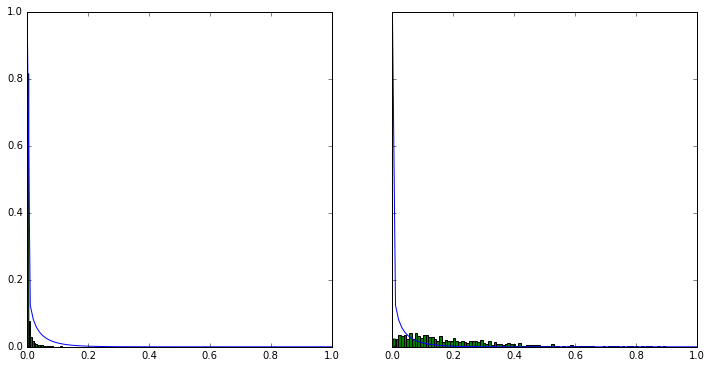

In [53]:
# checking out what this empirical distribution and the fitted gamma look like
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6), sharey=True)
x = np.linspace(0,1,100)
# unlabeled
ax0.plot(x, 1-empgam.cdf(x))
weights = np.ones_like(gvals)/len(gvals)
ax0.hist(gvals, 100, weights=weights)

#labeled
ax1.plot(x, 1-empgam.cdf(x))
weights = np.ones_like(pos_gs)/len(pos_gs)
ax1.hist(pos_gs, 100, weights=weights)

### Looking pretty good, let's check out outbreak windows now

In [54]:
#get random sample of 100 businesses
bs = db.query(b.Business.id).limit(10000).all()
bids = [biz.id for biz in bs]

In [55]:
samp = npr.choice(bids, 100)
print len(samp)

100


In [56]:
# all reviews for each of those businesses
%%time
revs = db.query(d.YelpReview).filter(d.YelpReview.business_id.in_(samp)).all()

In [57]:
print len(revs)

5905


In [58]:
# make a dictionary datastruct for each of those businesses by review for unlabeleds

ts = {}
for r in revs:
    try:
        ts[r.business_id].append((r.created, r.text, transform_doc(result_mixed['cv'], result_mixed['model'], r.text)))
    except KeyError:
        ts[r.business_id] = [(r.created, r.text, transform_doc(result_mixed['cv'], result_mixed['model'], r.text))]

In [59]:
# need slightly different form of labeled data for this (dates, and business)
import csv
with open('reviews_foodborne_date_biz.csv') as f:
    reader = csv.reader(f)
    reader.next()
    pos_data_n = [ row for row in reader if float(row[1]) == 1.0]
with open('reviews_foodborne_date_biz.csv') as f:
    reader = csv.reader(f)
    reader.next()
    neg_data_n = [ row for row in reader if float(row[1]) == 0.0]

In [783]:
# # make a dictionary datastruct of all reviews for the business associated with 100 labeled reviews
# ob = pos_data_n[posn:posn+100]
# os = {}
# for i, rev in enumerate(ob):
#     print i
#     biz = db.query(b.Business).filter(b.Business.name==unicode(rev[3])).first()
#     if not biz: continue
#     os[biz.id] = [ (r.created, r.text, transform_doc(result_mixed['cv'], result_mixed['model'], r.text)) for r in biz.reviews ]

In [62]:
# number of reviews for these businesses
print len([ t[2] for r in os.values() for t in r])

21579


In [63]:
# # lets look
# etas = [t[2][0,1] for a in os.values() for t in a]
# texts = [t[1] for a in os.values() for t in a]

In [64]:
# fig, ax = plt.subplots(1,1, figsize=(9,6))
# ax.plot(x, 1-empgam.cdf(x))
# #weights = np.ones_like(gvals)/len(gvals)
# #ax.hist(gvals, 100, alpha=.5, weights=weights)
# ax.hist(etas, 100, weights = np.ones_like(etas)/len(etas), alpha=.3)
# ax.set_ylim((0,.1))
# ax.set_xlim((0,.5))

In [66]:
# create the timedelta for creating windows
import datetime
# delta = datetime.timedelta(30) # two months
# delta = datetime.timedelta(15) # one month
delta = datetime.timedelta(30) # two week
# delta = datetime.timedelta(4) # one week

In [67]:
# get all of the reviews which we know are labeled as a list for convenience
knowns = [ unicode(r[0], 'utf-8') for r in ob]

In [68]:
# probs = [empgam.cdf(eta) for eta in etas]
# oldc =0
# for e,t in sorted(zip(probs, texts), key=lambda x:x[0], reverse=True)[:100]:
#     if t in knowns: 
#         new=False
#         oldc +=1
#     else: new=True
# #     print "%r, %r: %r"% (new, e,t)
# #     print

In [69]:
# get dict of biz names for display purposes
biz_names = {}
for bid in ts.keys():
    try:
        biz = db.query(b.Business).filter(b.Business.id==bid).first()  
        biz_names[bid] = biz.name
    except:
        biz_names[bid] = u"UNKNOWN"

for bid in os.keys():
    try:
        biz = db.query(b.Business).filter(b.Business.id==bid).first()  
        biz_names[bid] = biz.name
    except:
        biz_names[bid] = u"UNKNOWN"
        

In [70]:
outbreaks = []
windows = []

In [71]:
# get all windows associated with a business that had a labeled food poisoning review
for o in os.items():
    for datum in o[1]:
        revs = [ item for item in o[1] if (item[0] >= (datum[0]-delta))]
        window_d = [r[0] for r in revs ]
        window_t = [r[1] for r in revs ]
        window_eta =[r[2][0,1] for r in revs]
        if datum[1] in knowns: outbreak=True
        else: outbreak=False
        dic = {'biz': o[0],
               'bname': biz_names[o[0]],
               'window_d':window_d,
               'window_t': window_t,
               'window_eta':window_eta,
               'outbreak': outbreak}
        outbreaks.append(dic)

In [72]:
# do the same for the unlabeled random sample of restaurants
for o in ts.items():
    for datum in o[1]:
        revs = [ item for item in o[1] if (item[0] >= (datum[0]-delta)) ]
        window_d = [r[0] for r in revs ]
        window_t = [r[1] for r in revs ]
        window_eta =[r[2][0,1] for r in revs]
        if datum[1] in knowns: outbreak=True
        else: outbreak=False
        dic = {'biz': o[0],
               'bname': biz_names[o[0]],
               'window_d':window_d,
               'window_t': window_t,
               'window_eta':window_eta,
               'outbreak': outbreak}
        windows.append(dic)

In [73]:
#number of windows
print len(outbreaks)
print len(windows)

21579
5905


In [74]:
# avg number of docs in each window type (hopefully are similar)
print sum([len(w) for w in outbreaks])/float(len(outbreaks))
print sum([len(w) for w in windows])/float(len(windows))

6.0
6.0


In [75]:
# compute the window outbreak scores
for w in outbreaks:
    n = len(w['window_eta'])
    s = np.sum(np.array(w['window_eta']))
    gam = st.gamma(n*ahat, scale=1./bhat)
    score = gam.cdf(s)
#     print n, s, score
#     for date, eta,  t in sorted(zip(w['window_d'],w['window_eta'], w['window_t']), key=lambda x:x[0]):
#         print "%r, %0.3f, %r" % (date.strftime("%m-%d-%y"), eta, t)
#         print
#     print
#     print
    w['outbreak_score'] = score
    w['outbreak_s'] = s

In [76]:
# do the same for the unlabeled windows
for w in windows:
    n = len(w['window_eta'])
    s = np.sum(np.array(w['window_eta']))
    gam = st.gamma(n*ahat, scale=1./bhat)
    score = gam.cdf(s)
    #print n, s, score
    #for date, eta,  t in sorted(zip(w['window_d'],w['window_eta'], w['window_t']), key=lambda x:x[0]):
        #print "%r, %0.3f, %r" % (date.strftime("%m-%d-%y"), eta, t)
        #print
    #print
    #print
    w['outbreak_score'] = score
    w['outbreak_s'] = s

In [77]:
# compute the average outbreak score
w_scores = [ w['outbreak_score'] for w in windows]
o_scores = [ w['outbreak_score'] for w in outbreaks]
w_avg_score = np.sum(np.array(w_scores))/len(w_scores)
o_avg_score = np.sum(np.array(o_scores))/len(o_scores)

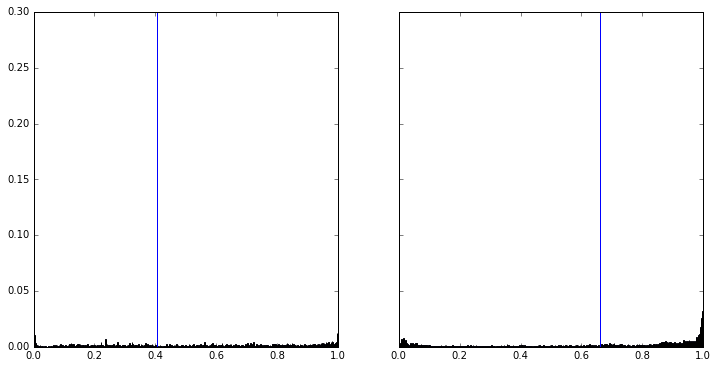

In [78]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6), sharey=True)
# plot how these scores look
weights = np.ones_like(w_scores)/len(w_scores)
# plt.plot(x, empgam.cdf(x))
ax0.hist(w_scores, 500, weights=weights)
ax0.axvline(x=w_avg_score)

oweights = np.ones_like(o_scores)/len(o_scores)
ax1.hist(o_scores, 500, weights=oweights)
ax1.axvline(x=o_avg_score)

In [79]:
# let's look at our top predictions
tops = sorted(windows, key=lambda x:x['outbreak_score'], reverse=True)

In [80]:
top = []
unique = []
for w in tops:
    if not w['bname'] in unique:
        top.append(w)
        unique.append(w['bname'])
        

In [782]:
# for w in top[:50]:
#     print "Biz: %r, Score: %.3f" % (w['bname'], w['outbreak_score'])
#     for date, eta,  t in sorted(zip(w['window_d'],w['window_eta'], w['window_t']), key=lambda x:x[0]):
#         print "%r, %0.3f, %r" % (date.strftime("%m-%d-%y"), eta, t)
#         print
#     print
#     print

In [82]:
# let's look at our top predictions
tops = sorted(outbreaks, key=lambda x:x['outbreak_score'], reverse=True)

In [83]:
top = []
unique = []
for w in tops:
    if not w['bname'] in unique:
        top.append(w)
        unique.append(w['bname'])
        

In [781]:
# for w in top[:50]:
#     print "Known?%s, Biz: %r, Score: %.3f" % (w['outbreak'],w['bname'], w['outbreak_score'])
#     for date, eta,  t in sorted(zip(w['window_d'],w['window_eta'], w['window_t']), key=lambda x:x[0]):
#         print "%r, %0.3f, %r" % ( date.strftime("%m-%d-%y"), eta, t)
#         print
#     print
#     print

### Ok, so it seems like it sort of works for outbreaks.  Let's try for individual reviews sample

In [85]:
ind_sample = [r.text for r in npr.choice(bigreviews, 10000, replace=False)]

In [86]:
ind_gs = [transform_doc(result_mixed['cv'], result_mixed['model'], t )[0,1] for t in ind_sample]

(array([  8.04000000e-01,   8.33000000e-02,   3.30000000e-02,
          1.78000000e-02,   1.12000000e-02,   7.90000000e-03,
          6.50000000e-03,   5.00000000e-03,   4.00000000e-03,
          3.70000000e-03,   2.50000000e-03,   2.70000000e-03,
          2.20000000e-03,   1.50000000e-03,   1.50000000e-03,
          1.10000000e-03,   1.80000000e-03,   9.00000000e-04,
          7.00000000e-04,   7.00000000e-04,   1.00000000e-04,
          5.00000000e-04,   3.00000000e-04,   2.00000000e-04,
          6.00000000e-04,   2.00000000e-04,   5.00000000e-04,
          2.00000000e-04,   3.00000000e-04,   4.00000000e-04,
          4.00000000e-04,   2.00000000e-04,   4.00000000e-04,
          2.00000000e-04,   2.00000000e-04,   3.00000000e-04,
          1.00000000e-04,   1.00000000e-04,   0.00000000e+00,
          2.00000000e-04,   1.00000000e-04,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e-04,   1.00000000e-04,
        

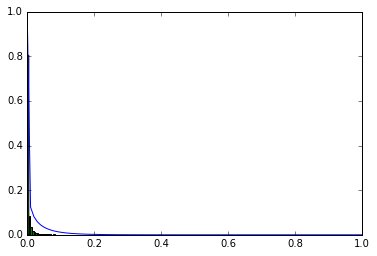

In [87]:
# does this look consistent?
x = np.linspace(0,1,100)
plt.plot(x, 1-empgam.cdf(x))

weights = np.ones_like(ind_gs)/len(ind_gs)
plt.hist(ind_gs, 100, weights=weights)

In [88]:
# so now lets print the docs in ranked reverse order by score
ind_scores = [ empgam.cdf(g) for g in ind_gs ]
for t, s in sorted(zip(ind_sample, ind_scores), key=lambda x:x[1], reverse=True):
    print "%.3f: %r" % (s,t)
    print

1.000: u'I found plastic in my food at the salad bar. \n\nI would have been very sick if I ate it. \n\nAlso, a woman at my office got norovirus here. \n\nAvoid, avoid, avoid.'

1.000: u'If you want to go to the hospital as I did, then eat here. Was diagnosed with Colitis after eating here, avoid at all cost. They have several violations from the NY state dept. of health and its mind blowing to me after being in the hospital for a few days that such a place is allowed to operate. \n\nThis place should be closed.\n\nUpdate: My case was not isolated and 2 others in my party experienced the same symptoms.'

1.000: u'I just ate here yesterday- Bistro salad and I am yakking and sick to stomach.  Bad salad and / or seafood- BEWARE.  Not worth it.'

1.000: u'Got diarrhea!! Please avoid!! The service is horrible. The pizza is usually good but this time I got pizza at 7pm and I knew it was a bad idea. The slices were not fresh and I got diarrhea 1 hour later. Super upset. Please stay away'

1.00

## Local Definition of the DiscLDA class

## Experiment 1 Testing DiscLDA accuracy for individual review classification

In [729]:
# pull in rows and sort them by date
rows = []
with open('reviews_foodborne_date_biz.csv') as f:
    for i, row in enumerate(csv.reader(f)):
        if i == 0 : continue
        row[1] = int(float(row[1]))
        row[2] = datetime.datetime.strptime(row[2], '%Y-%m-%d')
        rows.append(row)

# sort by date
rows = sorted(rows, key=lambda x:x[2], reverse=True)
            
# grab first 1000 by date
data = {'X':[], 'y':[]}
for i, row in enumerate(rows):
        data['X'].append(row[0])
        data['y'].append(row[1])
        if i == 1000:
            break
data['y'] = np.array(data['y'])

# grab sceond 1000 by date
testdata = {'X':[], 'y':[]}
for i, row in enumerate(rows[1001:]):
        testdata['X'].append(row[0])
        testdata['y'].append(row[1])
        #if i == 1000:
        #    break
testdata['y'] = np.array(testdata['y'])

In [730]:
print 'Positives: ', len([y for y in data['y'] if y == 1])
print 'Negatives: ', len([y for y in data['y'] if y == 0])

Positives:  501
Negatives:  500


In [731]:
print 'Positives: ', len([y for y in testdata['y'] if y == 1])
print 'Negatives: ', len([y for y in testdata['y'] if y == 0])

Positives:  2326
Negatives:  2067


In [732]:
from sklearn import cross_validation
folds = cross_validation.StratifiedKFold(data['y'], n_folds=3, random_state=0, shuffle=True)

In [733]:
%%time
disc_models = []
for n_top in [5,7,10]:
    print n_top
    preds = []
    truths = []
    # get all the CV predictions
    for fold in folds:
        train_X, train_y = np.array(data['X'])[fold[0]], data['y'][fold[0]]
        test_X, test_y = np.array(data['X'])[fold[1]], data['y'][fold[1]]
        model = run_disclda(train_X, train_y, n_topics=n_top, n_per=1, n_iter=1000, random_state=0)
        trainetas = model['model'].doc_topic_[:,1]
        testetas = np.array([transform_doc(model['cv'], model['model'], doc)[0,1] for doc in test_X])
        empgam = empgamma(trainetas) 
        testscores = empgam.cdf(testetas)
        preds.extend(list(testscores))
        truths.extend(list(test_y))
    # compute AUC over entire CV
    fpr, tpr, _ = roc_curve(truths, preds)
    s = auc(fpr, tpr)
    print "AUC: %.2f"% s
    # refit the model with whole train
    model = run_disclda(data['X'], data['y'], n_topics=n_top, n_per=1, n_iter=1000, random_state=0)
    disc_models.append((model, s))

5
Running LDA with 5 topics and 1000 iterations...
(N,V):  (667, 3115)

Running LDA with 5 topics and 1000 iterations...
(N,V):  (667, 2995)

Running LDA with 5 topics and 1000 iterations...
(N,V):  (668, 3050)

AUC: 0.82
Running LDA with 5 topics and 1000 iterations...
(N,V):  (1001, 3915)

7
Running LDA with 7 topics and 1000 iterations...
(N,V):  (667, 3115)

Running LDA with 7 topics and 1000 iterations...
(N,V):  (667, 2995)

Running LDA with 7 topics and 1000 iterations...
(N,V):  (668, 3050)

AUC: 0.82
Running LDA with 7 topics and 1000 iterations...
(N,V):  (1001, 3915)

10
Running LDA with 10 topics and 1000 iterations...
(N,V):  (667, 3115)

Running LDA with 10 topics and 1000 iterations...
(N,V):  (667, 2995)

Running LDA with 10 topics and 1000 iterations...
(N,V):  (668, 3050)

AUC: 0.82
Running LDA with 10 topics and 1000 iterations...
(N,V):  (1001, 3915)

CPU times: user 3min 47s, sys: 1.29 s, total: 3min 48s
Wall time: 4min 9s


In [734]:
# take the best disclda
result_bias = sorted(disc_models, key=lambda x:x[1], reverse=True)[0][0]

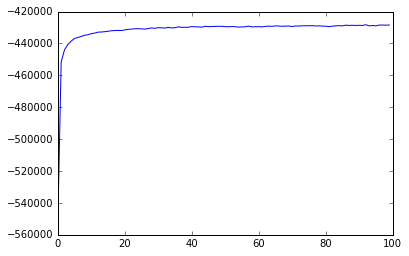

In [735]:
plt.plot( result_bias['model'].loglikelihoods_)

In [736]:
thetas = result_bias['model'].doc_topic_
fitetas = thetas[:,1]
#print len(thetas[data['y'] == 0])
#print data['y']

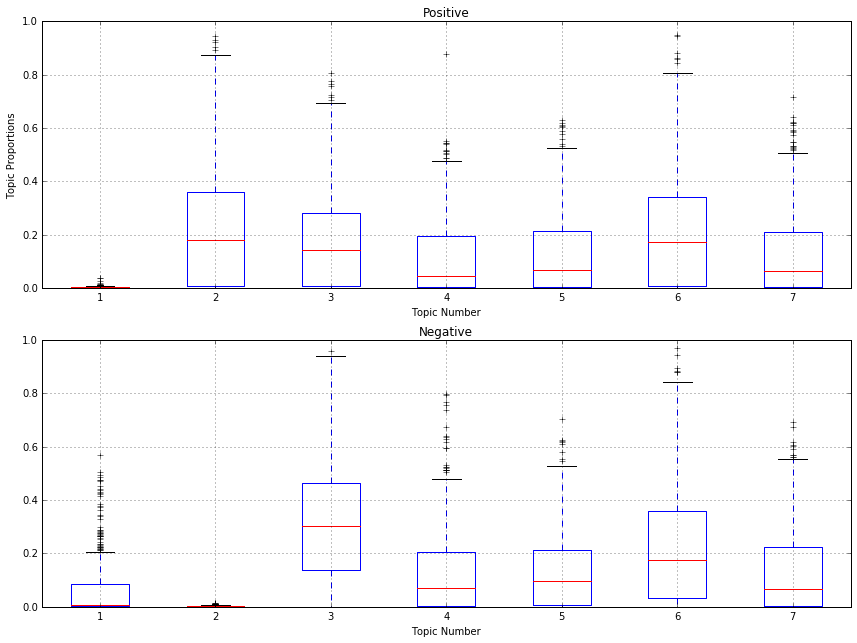

In [737]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,9), sharey=True)
ax0.boxplot(thetas[np.where(data['y'] == 1)])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(thetas[np.where(data['y'] == 0)])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Negative")
ax1.set_xlabel("Topic Number")

plt.tight_layout()
#plt.savefig('lda_boxplot_2500_7500.pdf')

In [738]:
print_topics(result_bias['model'], result_bias['vocab'], top_k=20)

	Topic 1: like, tea, cream, cake, ice, sweet, chocolate, good, green, flavors, favorite, flavor, fruit, amazing, super, dessert, iced, cute, butter, birthday

	Topic 2: food, poisoning, got, sick, day, eating, night, stomach, place, diarrhea, time, days, eat, ordered, went, restaurant, ate, good, bad, boyfriend

	Topic 3: sick, place, good, great, don, just, food, really, time, think, eat, nice, like, people, try, day, going, know, ve, feel

	Topic 4: ordered, like, burger, sick, chicken, just, good, cheese, got, sandwich, pizza, little, didn, tasted, make, home, sauce, bread, fries, cold

	Topic 5: restaurant, came, food, table, service, minutes, asked, waiter, waitress, didn, order, experience, told, did, went, ordered, menu, manager, said, dinner

	Topic 6: food, place, time, just, sick, order, don, got, like, know, people, away, said, bad, ve, poisoning, customer, service, times, make

	Topic 7: food, chicken, sushi, fish, good, fresh, sick, ve, soup, rice, roll, salad, spicy, eat,

In [739]:
testthetas = np.array([transform_doc(result_bias['cv'], result_bias['model'], doc)[0,:] for doc in testdata['X']])

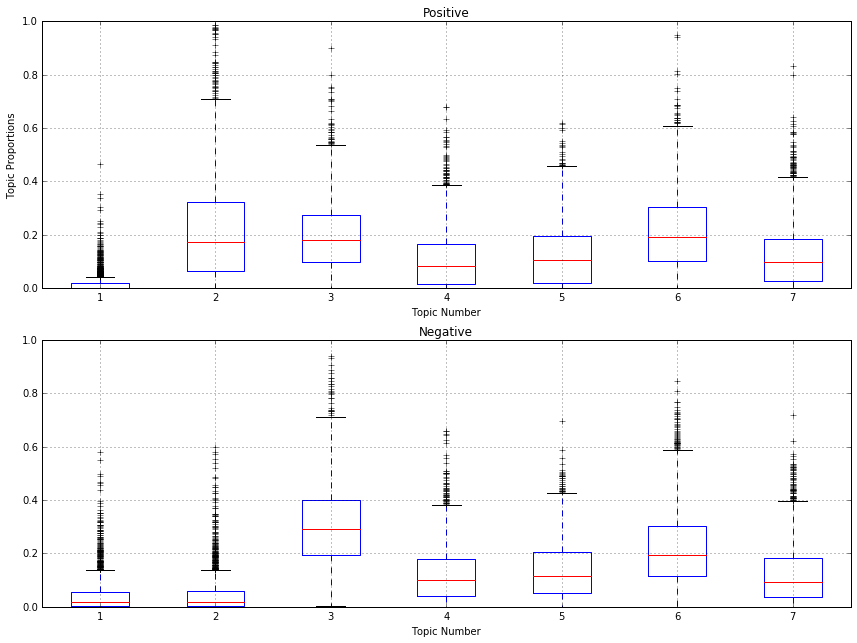

In [740]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,9), sharey=True)
ax0.boxplot(testthetas[np.where(testdata['y'] == 1)])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(testthetas[np.where(testdata['y'] == 0)])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Negative")
ax1.set_xlabel("Topic Number")

plt.tight_layout()

In [741]:
testlabels = testdata['y']
testscores = testthetas[:,1]

#convert them to gamma probs
#print thetas
testgamma = empgamma(thetas[:,1]) 
testscores = testgamma.cdf(testscores)
#print testscores

In [742]:
from sklearn.metrics import roc_curve, auc

In [743]:
%%time
logreg_models = []
for C in [.01, .05, .1, .5, 1., 2.]:
    print C
    preds = []
    truths = []
    # get all the CV predictions
    for fold in folds:
        train_X, train_y = np.array(data['X'])[fold[0]], data['y'][fold[0]]
        test_X, test_y = np.array(data['X'])[fold[1]], data['y'][fold[1]]
        lr = LogisticRegression(C=C,
                        fit_intercept=True,
                        random_state=0,
                        n_jobs=2)
        cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=2, ngram_range=(1,1))
        trainX = cv.fit_transform(train_X)
        lr.fit(trainX, train_y)
        testX = cv.transform(test_X)
        lrscores = lr.predict_proba(testX)[:,1]
        preds.extend(list(lrscores))
        truths.extend(list(test_y))
    # compute AUC over entire CV
    fpr, tpr, _ = roc_curve(truths, preds)
    s = auc(fpr, tpr)
    print "AUC: %.2f"% s
    # refit the model on whole train
    lr = LogisticRegression(C=C,
                        fit_intercept=True,
                        random_state=0,
                        n_jobs=2) 
    cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=2, ngram_range=(1,1))
    X = cv.fit_transform(data['X'])
    lr.fit(X, data['y']) 
    logreg_models.append((lr, s))

0.01
AUC: 0.83
0.05
AUC: 0.84
0.1
AUC: 0.84
0.5
AUC: 0.83
1.0
AUC: 0.82
2.0
AUC: 0.82
CPU times: user 6.57 s, sys: 75.5 ms, total: 6.64 s
Wall time: 8 s


In [706]:

# lr = LogisticRegression(C=1.0,
#                         fit_intercept=True,
#                         random_state=0,
#                         n_jobs=2)
# sv = svm.SVC( C=1.0,
#               kernel='linear')
# svr = svm.SVC( C=1.0,
#               kernel='rbf')

In [707]:
# lr.fit(result_bias['X'], data['y'])
# sv.fit(result_bias['X'], data['y'])
# svr.fit(result_bias['X'], data['y'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [771]:
# take best LOGREG from CV
lr = sorted(logreg_models, key=lambda x:x[1], reverse=True)[0][0]

In [772]:
fpr, tpr, _ = roc_curve(testlabels, testscores)
s = auc(fpr, tpr)

In [773]:
testX = result_bias['cv'].transform(testdata['X'])
lrscores = lr.predict_proba(testX)[:,1]
# svscores = sv.decision_function(testX)[:]
# svrscores = svr.decision_function(testX)[:]

In [774]:
lrfpr, lrtpr, _ = roc_curve(testlabels, lrscores)
lrs = auc(lrfpr, lrtpr)
# svfpr, svtpr, _ = roc_curve(testlabels, svscores)
# svs = auc(svfpr, svtpr)
# svrfpr, svrtpr, _ = roc_curve(testlabels, svrscores)
# svrs = auc(svrfpr, svrtpr)

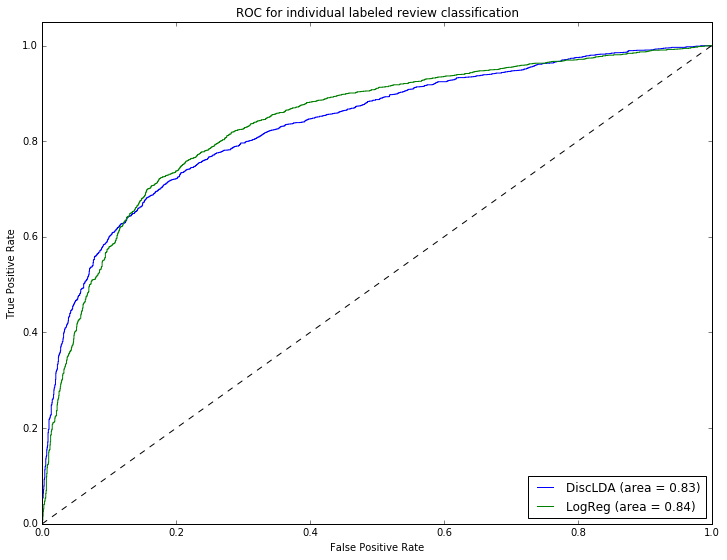

In [778]:
plt.figure(figsize=(12,9))
plt.plot(fpr, tpr, label='DiscLDA (area = %0.2f)' % s)
plt.plot(lrfpr, lrtpr, label='LogReg (area = %0.2f)'% lrs)
# plt.plot(svfpr, svtpr, label='SVM (area = %0.2f)'% svs)
# plt.plot(svrfpr, svrtpr, label='SVM RBF (area = %0.2f)'% svrs)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for individual labeled review classification')
plt.legend(loc="lower right")

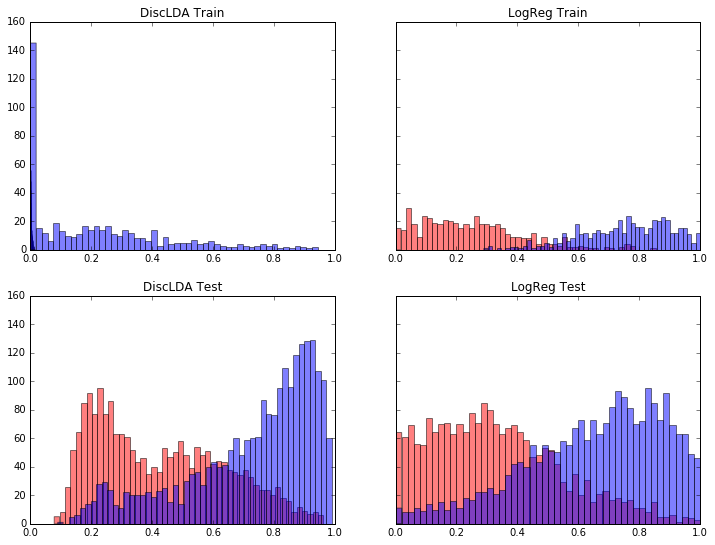

In [776]:
# plot the histograms of the values for each
# normalize decision function scores
norm_svscores = (1./(max(svscores)-min(svscores)))*(svscores - min(svscores))
norm_svrscores = (1./(max(svrscores)-min(svrscores)))*(svrscores - min(svrscores))

fig, axarr = plt.subplots(2,2, figsize=(12,9), sharey=True)
### TRAIN DISTRIBUTIONS
axarr[0,0].hist(thetas[np.where(data['y'] == 0)][:,1], 50, alpha=.5, color='r')
axarr[0,0].hist(thetas[np.where(data['y'] == 1)][:,1], 50, alpha=.5, color='b')
axarr[0,0].set_title("DiscLDA Train")

# axarr[0,1].hist(lrscores)
axarr[0,1].hist(lr.predict_proba(result_bias['X'][np.where(data['y'] == 0)])[:,1], 50, alpha=.5, color='r')
axarr[0,1].hist(lr.predict_proba(result_bias['X'][np.where(data['y'] == 1)])[:,1], 50, alpha=.5, color='b')
axarr[0,1].set_title("LogReg Train")

### TEST DISTRIBUTIONS
axarr[1,0].hist(testscores[np.where(testlabels ==0)], 50, alpha=.5, color='r')
axarr[1,0].hist(testscores[np.where(testlabels ==1)], 50, alpha=.5, color='b')
axarr[1,0].set_title("DiscLDA Test")

# axarr[0,1].hist(lrscores)
axarr[1,1].hist(lrscores[np.where(testlabels ==0)], 50, alpha=.5, color='r')
axarr[1,1].hist(lrscores[np.where(testlabels ==1)], 50, alpha=.5, color='b')
axarr[1,1].set_title("LogReg Test")

# axarr[1,0].hist(norm_svscores)
# axarr[1,0].hist([s for s in norm_svscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
# axarr[1,0].hist([s for s in norm_svscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

# # axarr[1,1].hist(norm_svrscores)
# axarr[1,1].hist([s for s in norm_svrscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
# axarr[1,1].hist([s for s in norm_svrscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

## Experiment 2 Testing DiscLDA accuracy for individual review classification for unlabeleds

In [553]:
# what happens when I add some unlabeleds for context

In [675]:
# # pull in rows and sort them by date
# rows = []
# with open('reviews_foodborne_date_biz.csv') as f:
#     for i, row in enumerate(csv.reader(f)):
#         if i == 0 : continue
#         row[1] = int(float(row[1]))
#         row[2] = datetime.datetime.strptime(row[2], '%Y-%m-%d')
#         rows.append(row)

# # sort by date
# rows = sorted(rows, key=lambda x:x[2], reverse=True)
            
# # grab first 1000 by date
# data = {'X':[], 'y':[]}
# for i, row in enumerate(rows):
#         data['X'].append(row[0])
#         data['y'].append(row[1])
#         if i == 1000:
#             break
# data['y'] = np.array(data['y'])

# # grab sceond 1000 by date
# testdata = {'X':[], 'y':[]}
# for i, row in enumerate(rows[1001:2001]):
#         testdata['X'].append(row[0])
#         testdata['y'].append(row[1])
#         if i == 1000:
#             break
# testdata['y'] = np.array(testdata['y'])
# print data['y'].shape

In [676]:
# # supplement negative with a bunch of unlabeled
# n_extra = 10000
# unlabeled = [ t.text for t in np.random.choice(bigreviews, n_extra, replace=False)]
# data['X'].extend(unlabeled)
# data['y'] = np.append(data['y'],np.zeros(len(unlabeled)))

In [677]:
# result_bias = run_disclda(data['X'], data['y'], n_topics=10, n_iter=500)#run_disclda(data, labels, n_topics=10, n_per=1, n_iter=1000, random_state=0)

In [678]:
# plt.plot(result_bias['model'].loglikelihoods_)

In [679]:
# thetas = result_bias['model'].doc_topic_
# fitthetas=thetas
# #print len(thetas[data['y'] == 0])
# #print data['y']

In [680]:
### THE EMPIRICALLY FIT GAMMA

In [681]:
# fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,9), sharey=True)
# ax0.boxplot(thetas[np.where(data['y'] == 1)])
# ax0.grid()
# ax0.set_title("Positive")
# ax0.set_xlabel("Topic Number")
# ax0.set_ylabel("Topic Proportions")
# ax1.boxplot(thetas[np.where(data['y'] == 0)])#np.random.randint(2500,10000,size=2500),:])
# ax1.grid()
# ax1.set_title("Negative")
# ax1.set_xlabel("Topic Number")

# plt.tight_layout()
# #plt.savefig('lda_boxplot_2500_7500.pdf')

In [682]:
# print_topics(result_bias['model'], result_bias['vocab'], top_k=20)

In [683]:
# testthetas = np.array([transform_doc(result_bias['cv'], result_bias['model'], doc)[0,:] for doc in testdata['X']])

In [684]:
# fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,9), sharey=True)
# ax0.boxplot(testthetas[np.where(testdata['y'] == 1)])
# ax0.grid()
# ax0.set_title("Positive")
# ax0.set_xlabel("Topic Number")
# ax0.set_ylabel("Topic Proportions")
# ax1.boxplot(testthetas[np.where(testdata['y'] == 0)])#np.random.randint(2500,10000,size=2500),:])
# ax1.grid()
# ax1.set_title("Negative")
# ax1.set_xlabel("Topic Number")

# plt.tight_layout()

In [685]:
# testlabels = testdata['y']
# testscores = testthetas[:,1]

# #convert them to gamma probs
# #print thetas
# testgamma = empgamma(thetas[:,1])
# testscores = testgamma.cdf(testscores)
# #print testscores

In [686]:
# # define baseline pipelines
# from sklearn.linear_model import LogisticRegression
# from sklearn import svm

# lr = LogisticRegression(C=1.0,
#                         fit_intercept=True,
#                         random_state=0,
#                         n_jobs=2)
# sv = svm.SVC( C=1.0,
#               kernel='linear')
# svr = svm.SVC( C=1.0,
#               kernel='rbf')
# lr.fit(result_bias['X'], data['y'])
# sv.fit(result_bias['X'], data['y'])
# svr.fit(result_bias['X'], data['y'])

In [687]:
# fpr, tpr, _ = roc_curve(testlabels, testscores)
# s = auc(fpr, tpr)

# testX = result_bias['cv'].transform(testdata['X'])
# lrscores = lr.predict_proba(testX)[:,1]
# svscores = sv.decision_function(testX)[:]
# svrscores = svr.decision_function(testX)[:]

# lrfpr, lrtpr, _ = roc_curve(testlabels, lrscores)
# lrs = auc(lrfpr, lrtpr)
# svfpr, svtpr, _ = roc_curve(testlabels, svscores)
# svs = auc(svfpr, svtpr)
# svrfpr, svrtpr, _ = roc_curve(testlabels, svrscores)
# svrs = auc(svrfpr, svrtpr)

In [688]:
# plt.figure()
# plt.plot(fpr, tpr, label='DiscLDA (area = %0.2f)' % s)
# plt.plot(lrfpr, lrtpr, label='LogReg (area = %0.2f)'% lrs)
# plt.plot(svfpr, svtpr, label='SVM (area = %0.2f)'% svs)
# plt.plot(svrfpr, svrtpr, label='SVM RBF (area = %0.2f)'% svrs)


# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")

In [689]:
# # plot the histograms of the values for each
# # normalize decision function scores
# norm_svscores = (1./(max(svscores)-min(svscores)))*(svscores - min(svscores))
# norm_svrscores = (1./(max(svrscores)-min(svrscores)))*(svrscores - min(svrscores))

# fig, axarr = plt.subplots(2,2, figsize=(12,9), sharey=True)
# axarr[0,0].hist([s for s in testscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
# axarr[0,0].hist([s for s in testscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

# # axarr[0,1].hist(lrscores)
# axarr[0,1].hist([s for s in lrscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
# axarr[0,1].hist([s for s in lrscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

# # axarr[1,0].hist(norm_svscores)
# axarr[1,0].hist([s for s in norm_svscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
# axarr[1,0].hist([s for s in norm_svscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

# # axarr[1,1].hist(norm_svrscores)
# axarr[1,1].hist([s for s in norm_svrscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
# axarr[1,1].hist([s for s in norm_svrscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

## INCIDENT WINDOWS EXPERIMENT

In [554]:
# # pull in rows and sort them by date
# rows = []
# with open('reviews_foodborne_date_biz.csv') as f:
#     for i, row in enumerate(csv.reader(f)):
#         if i == 0 : continue
#         row[1] = int(float(row[1]))
#         row[2] = datetime.datetime.strptime(row[2], '%Y-%m-%d')
#         rows.append(row)

# # sort by date
# rows = sorted(rows, key=lambda x:x[2], reverse=True)
            
# # grab first 1000 by date
# data = {'X':[], 'y':[], 'biz':[]}
# for i, row in enumerate(rows):
#         data['X'].append(row[0])
#         data['y'].append(row[1])
#         data['biz'].append(unicode(row[3], 'utf8'))
#         if i == 1000:
#             break
# #data['y'] = np.array(data['y'])

# # test on the rest
# testdata = {'X':[], 'y':[], 'biz':[] }
# for i, row in enumerate(rows[1001:]):
#         testdata['X'].append(row[0])
#         testdata['y'].append(row[1])
#         testdata['biz'].append(unicode(row[3], 'utf8'))
#         #if i == 1000:
#         #    break
# #testdata['y'] = np.array(testdata['y'])

In [555]:
print len(rows[1001:])
print len(testdata['y'])

4393
4393


In [779]:
# %%time
# db = m.getDBSession()
# # get the biz id (first if ambiguous) for the business name for each review
# # make a dictionary of them
# bids = {}
# # for bname in data['biz']:
# #     bids[bname] = db.query(b.Business).filter(b.Business.name==bname).first()
# for i, bname in enumerate(testdata['biz']):
#     bids[bname] = db.query(b.Business).filter(b.Business.name==bname).first()
#     print i

In [ ]:
# %%time
# #create the know incident windows
# db = m.getDBSession()
# delta = datetime.timedelta(30) # one month back
# windows_test = []
# dbc = 0
# mrc = 0
# for i, row in enumerate(zip(testdata['X'], testdata['y'], testdata['biz'])):
#     x, y, biz = row[0], row[1], row[2]
#     print i , " ::: ", biz, bids[biz]
#     obj = {}
#     mainrev = False
#     if not bids[biz]:
#         dbc +=1
#         print "\t%i: Restaurant not found in db. Skipping" % dbc
#         continue
#     for rev in bids[biz].reviews:
#         if x == rev.text:
#             mainrev = rev
#             break
#     if not mainrev:
#         mrc +=1
#         print "\t%i: Failed to get main review from business, skipping" % mrc
#         continue
#     window  = [ rev for rev in bids[biz].reviews if (rev.created >= (mainrev.created - delta)) and (rev.created <= mainrev.created)]
#     obj['window'] = window
#     obj['label'] = y
#     obj['biz'] = biz
#     windows_test.append(obj)

In [723]:
print "Prior: %i" % len(testdata['y'])
print 'Neg ', len([ w for w in testdata['y'] if w == 0])
print 'Pos ', len([ w for w in testdata['y'] if w == 1])
print
print 'All %i, %.2f'% ( len(windows_test), len(windows_test)/float(len(testdata['y'])))
print 'Neg %i, %.2f '% (len([ w for w in windows_test if w['label'] == 0]), len([ w for w in windows_test if w['label'] == 0])/float(len([ w for w in testdata['y'] if w == 0])))
print 'Pos %i, %.2f '% (len([ w for w in windows_test if w['label'] == 1]), len([ w for w in windows_test if w['label'] == 1])/float(len([ w for w in testdata['y'] if w == 1])))


Prior: 4393
Neg  2067
Pos  2326

All 2489, 0.57
Neg 1157, 0.56 
Pos 1332, 0.57 


In [724]:
print thetas.shape
print fitetas.shape

(1001, 7)
(1001,)


In [763]:
%%time
# give a prediction for each window based on DiscLDA
for w in windows_test:
    # get disclda score
    n = len(w['window'])
    etas = [ transform_doc(result_bias['cv'], result_bias['model'], rev.text)[0,1] for rev in w['window']]
    sumeta = sum(etas)
    w['disclda_avg'] = sumeta/float(n)
    score = empgamma(fitetas, n=n).cdf(sumeta)
    w['disclda_score'] = score
    w['disclda_max'] = max(etas)
    # try just averaging disclda scores
    w['etas']= etas
    
    #get logreg average prob score
    x = result_bias['cv'].transform([rev.text for rev in w['window']])
    lrscores = lr.predict_proba(x)[:,1]
    w['lrs'] = lrscores
    avg_lrscore = sum(lrscores)/float(n)
    w['logreg_avg'] = avg_lrscore
    w['logreg_max'] = max(lrscores)

CPU times: user 43.6 s, sys: 347 ms, total: 43.9 s
Wall time: 50.8 s


In [764]:
window_labels = [w['label'] for w in windows_test]
dlscores = [w['disclda_score'] for w in windows_test]
dascores = [w['disclda_avg'] for w in windows_test]
dmscores = [w['disclda_max'] for w in windows_test]
lrscores = [w['logreg_avg'] for w in windows_test]
lmscores = [w['logreg_max'] for w in windows_test]

lrfpr, lrtpr, _ = roc_curve(window_labels, lrscores)
lrs = auc(lrfpr, lrtpr)
lmfpr, lmtpr, _ = roc_curve(window_labels, lmscores)
lms = auc(lmfpr, lmtpr)
dlfpr, dltpr, _ = roc_curve(window_labels, dlscores)
dls = auc(dlfpr, dltpr)
dafpr, datpr, _ = roc_curve(window_labels, dascores)
das = auc(dafpr, datpr)
dmfpr, dmtpr, _ = roc_curve(window_labels, dmscores)
dms = auc(dmfpr, dmtpr)

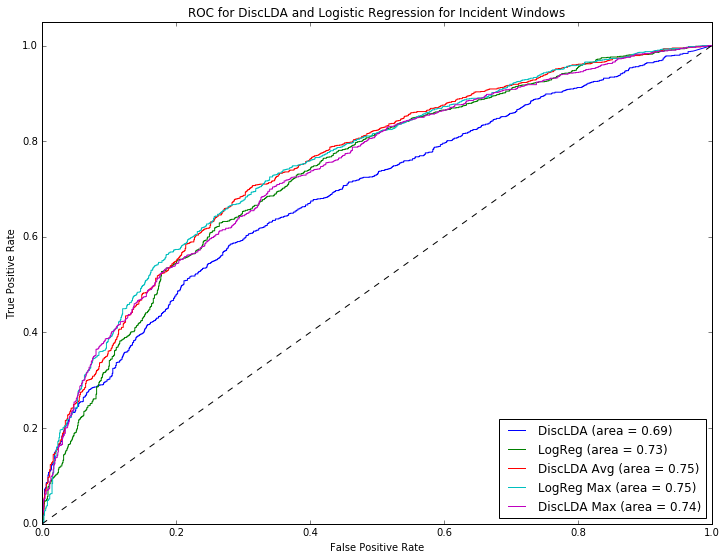

In [769]:
plt.figure(figsize = (12,9))
plt.plot(dlfpr, dltpr, label='DiscLDA (area = %0.2f)' % dls)
plt.plot(lrfpr, lrtpr, label='LogReg (area = %0.2f)'% lrs)
plt.plot(dafpr, datpr, label='DiscLDA Avg (area = %0.2f)'% das)
plt.plot(lmfpr, lmtpr, label='LogReg Max (area = %0.2f)'% lms)
plt.plot(dmfpr, dmtpr, label='DiscLDA Max (area = %0.2f)'% dms)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for DiscLDA and Logistic Regression for Incident Windows')
plt.legend(loc="lower right")

In [530]:
def print_windows(windows, k=100):
    for window in windows:
        win = window['window']
        etas, lrs = window['etas'], window['lrs']
        lgs, dls = window['logreg_avg'], window['disclda_score']
        print '%r:%i: LR: %.2f DL: %.2f' % (window['biz'], window['label'], lgs, dls)
        for i, w in enumerate(win):
            print '\t%i:: LR: %.2f DL: %.2f' % (i, lrs[i], etas[i])
            print '\t%r' % w.text
            if i >= k: break
        print

In [623]:
discsort = sorted(windows_test, key=lambda x:x['disclda_score'], reverse=True)

In [780]:
# print_windows(discsort, k=50)

## Learn Best LogReg and DiscLDA

In [493]:
from sklearn import cross_validation
folds = cross_validation.StratifiedKFold(data['y'], n_folds=3, random_state=0, shuffle=True)

5
Running LDA with 5 topics and 1000 iterations...
(N,V):  (667, 3115)

Running LDA with 5 topics and 1000 iterations...
(N,V):  (667, 2995)

Running LDA with 5 topics and 1000 iterations...
(N,V):  (668, 3050)

AUC: 0.82
Running LDA with 5 topics and 1000 iterations...
(N,V):  (1001, 3915)

6
Running LDA with 6 topics and 1000 iterations...
(N,V):  (667, 3115)

Running LDA with 6 topics and 1000 iterations...
(N,V):  (667, 2995)

Running LDA with 6 topics and 1000 iterations...
(N,V):  (668, 3050)

AUC: 0.82
Running LDA with 6 topics and 1000 iterations...
(N,V):  (1001, 3915)

7
Running LDA with 7 topics and 1000 iterations...
(N,V):  (667, 3115)

Running LDA with 7 topics and 1000 iterations...
(N,V):  (667, 2995)

Running LDA with 7 topics and 1000 iterations...
(N,V):  (668, 3050)

AUC: 0.82
Running LDA with 7 topics and 1000 iterations...
(N,V):  (1001, 3915)

8
Running LDA with 8 topics and 1000 iterations...
(N,V):  (667, 3115)

Running LDA with 8 topics and 1000 iterations...


0.01
AUC: 0.83
0.05
AUC: 0.84
0.1
AUC: 0.84
0.5
AUC: 0.83
1.0
AUC: 0.82
2.0
AUC: 0.82
CPU times: user 6.08 s, sys: 30.6 ms, total: 6.11 s
Wall time: 6.18 s
